In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

preprocessed_path = r"D:\Infosys Intern\CreditPathAI_Oct_Batch\kaggle_dataset\data\03_processed\loan_data_preprocessed.csv"
df = pd.read_csv(preprocessed_path)



In [ ]:

target_col = "repay_fail"
X = df.drop(columns=[target_col])
result = df[target_col]

print("Initial Shape:", X.shape)

Initial Shape: (38479, 42)


In [11]:
# Drop columns fully missing
cols_to_drop = [col for col in X.columns if X[col].isnull().sum() == len(X)]
X.drop(columns=cols_to_drop, inplace=True)
print("Dropped Columns:", cols_to_drop)

# Convert boolean columns → integers
bool_cols = X.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    X[bool_cols] = X[bool_cols].astype(int)
    print("Converted Bool → Int:", bool_cols)

# Detect numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Impute numeric values
num_imputer = SimpleImputer(strategy="median")
X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])

# Impute categorical values (if any)
if cat_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

print("Missing values after cleanup:", X.isnull().sum().sum())


Dropped Columns: []
Missing values after cleanup: 0


In [14]:


X_train, X_test, y_train, y_test = train_test_split(
    X, result,
    test_size=0.2,
    stratify=result,
    random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Before SMOTE:", y_train.value_counts().to_dict())


Train: (30783, 41) Test: (7696, 41)
Before SMOTE: {0: 26121, 1: 4662}


In [15]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_sm.value_counts().to_dict())

After SMOTE: {0: 26121, 1: 26121}


In [16]:





models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss')
}



trained_models = {}





for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    trained_models[name] = model



In [17]:
print("\n MODEL PERFORMANCE SUMMARY\n")

for name, model in trained_models.items():

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    print(f"\n------ {name} ------")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", auc if auc else "N/A")


 MODEL PERFORMANCE SUMMARY


------ Logistic Regression ------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6530
           1       0.98      0.98      0.98      1166

    accuracy                           1.00      7696
   macro avg       0.99      0.99      0.99      7696
weighted avg       1.00      1.00      1.00      7696

ROC-AUC: 0.995139073126013

------ Random Forest ------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6530
           1       1.00      0.99      1.00      1166

    accuracy                           1.00      7696
   macro avg       1.00      1.00      1.00      7696
weighted avg       1.00      1.00      1.00      7696

ROC-AUC: 0.9999942868250244

------ Decision Tree ------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6530
           1       1.00      1.00      1.00      1166

    a

In [18]:
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


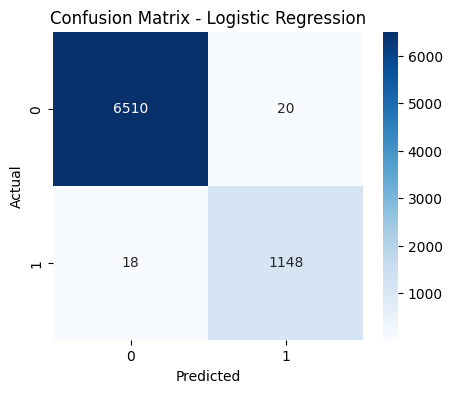

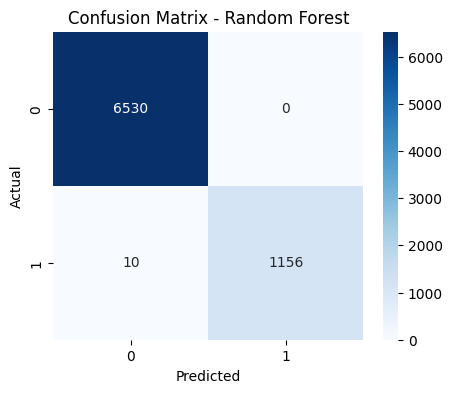

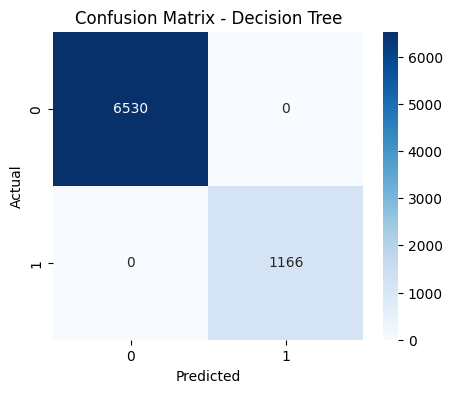

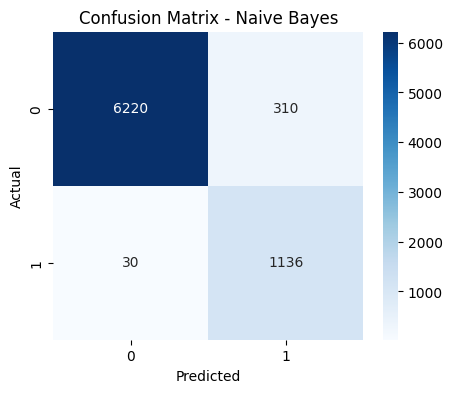

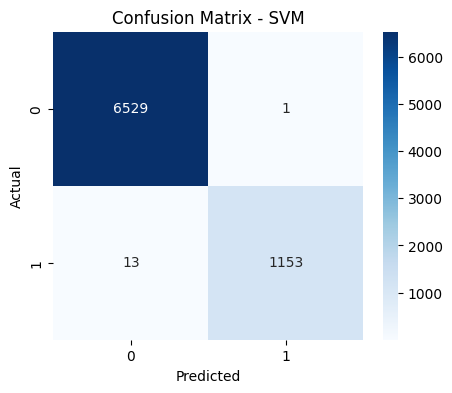

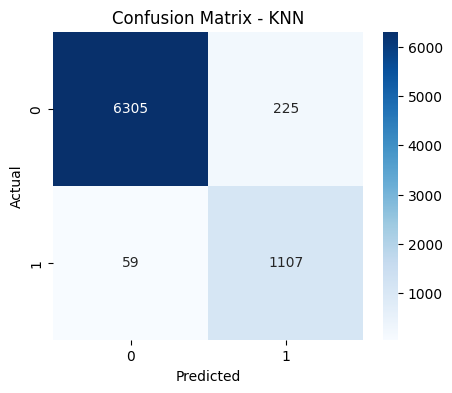

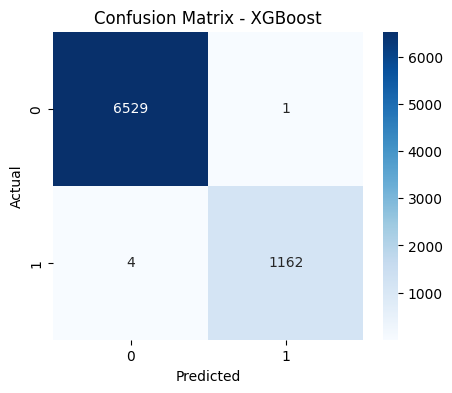

In [19]:
for name, model in trained_models.items():
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


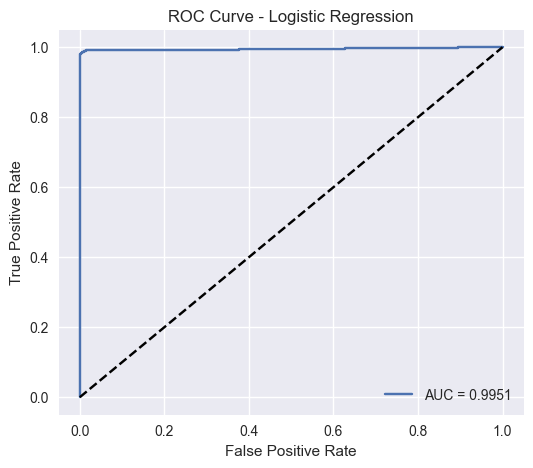

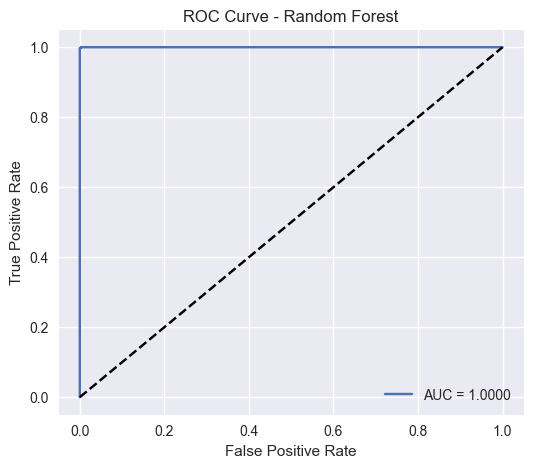

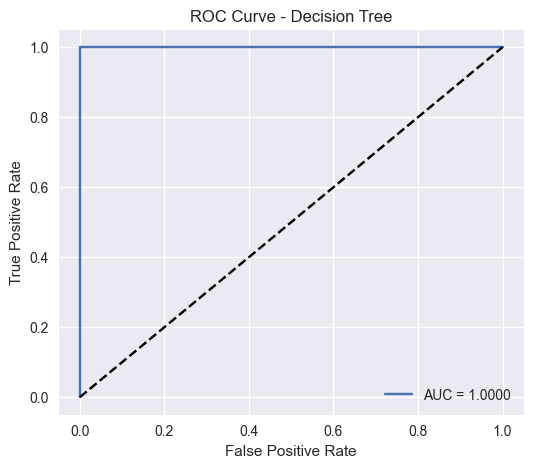

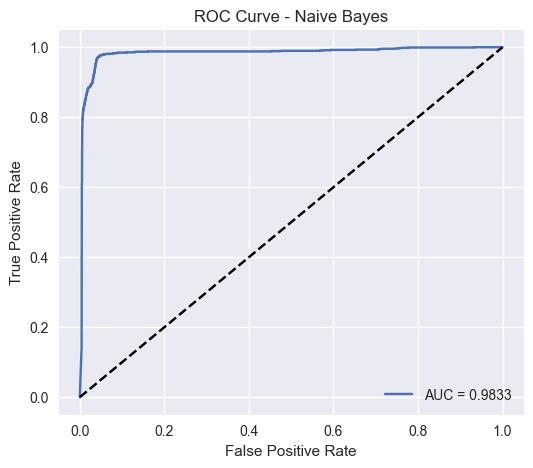

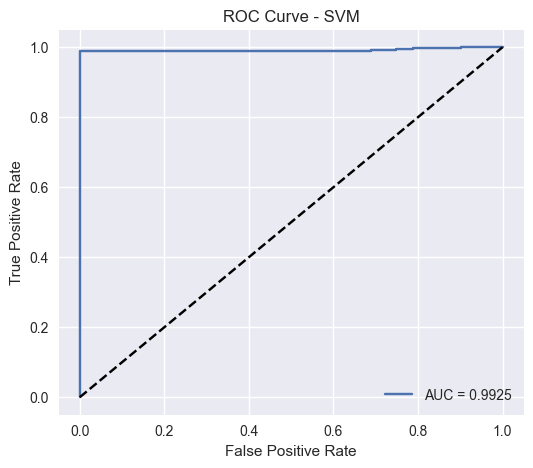

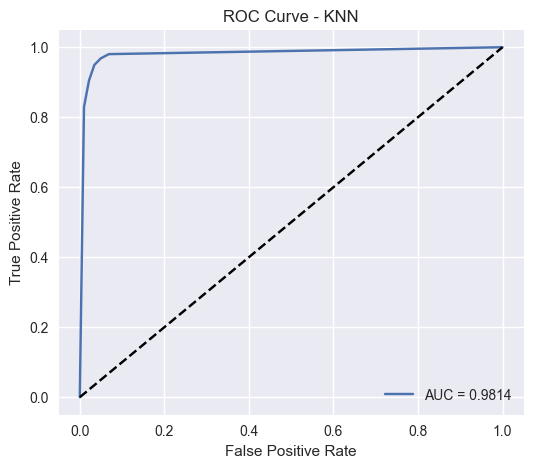

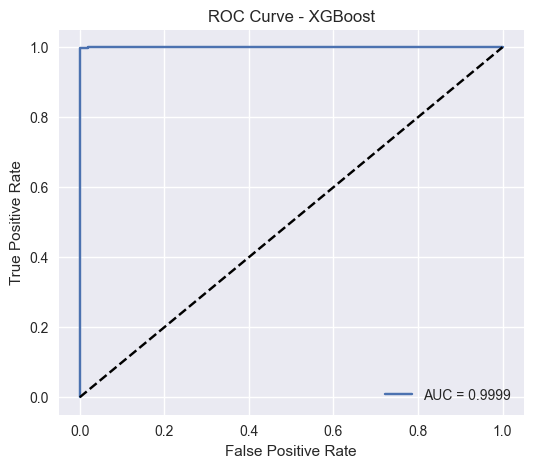

In [20]:
plt.style.use("seaborn-v0_8")

for name, model in trained_models.items():

    if not hasattr(model, "predict_proba"):
        print(f"{name} does not support probability. Skipping ROC.")
        continue

    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()


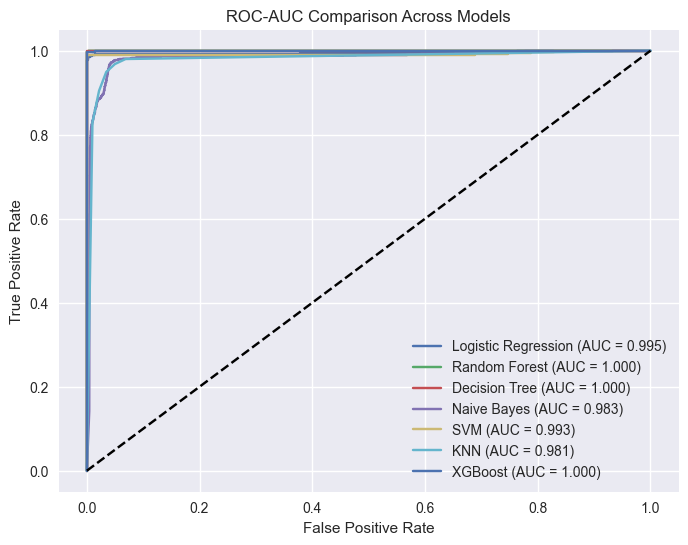

In [21]:
plt.figure(figsize=(8,6))
plt.title("ROC-AUC Comparison Across Models")

for name, model in trained_models.items():

    if not hasattr(model, "predict_proba"):
        continue


    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [22]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

print(" MODEL PERFORMANCE ")

for name, model in trained_models.items():


    y_train_pred = model.predict(X_train_sm)
    y_train_prob = model.predict_proba(X_train_sm)[:, 1] if hasattr(model, "predict_proba") else None
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    train_acc = accuracy_score(y_train_sm, y_train_pred)
    train_prec = precision_score(y_train_sm, y_train_pred)
    train_rec = recall_score(y_train_sm, y_train_pred)
    train_f1 = f1_score(y_train_sm, y_train_pred)
    train_auc = roc_auc_score(y_train_sm, y_train_prob) if y_train_prob is not None else None
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_prob) if y_test_prob is not None else None


    print(f"------- {name} -------")
    print(f"Train Accuracy  : {train_acc:.4f}")
    print(f"Train Precision : {train_prec:.4f}")
    print(f"Train Recall    : {train_rec:.4f}")
    print(f"Train F1 Score  : {train_f1:.4f}")
    print(f"Train ROC-AUC   : {train_auc:.4f}" if train_auc else "Train ROC-AUC : N/A")

    print(f"Test Accuracy   : {test_acc:.4f}")
    print(f"Test Precision  : {test_prec:.4f}")
    print(f"Test Recall     : {test_rec:.4f}")
    print(f"Test F1 Score   : {test_f1:.4f}")
    print(f"Test ROC-AUC    : {test_auc:.4f}" if test_auc else "Test ROC-AUC : N/A")


 MODEL PERFORMANCE 
------- Logistic Regression -------
Train Accuracy  : 0.9951
Train Precision : 0.9969
Train Recall    : 0.9933
Train F1 Score  : 0.9951
Train ROC-AUC   : 0.9975
Test Accuracy   : 0.9951
Test Precision  : 0.9829
Test Recall     : 0.9846
Test F1 Score   : 0.9837
Test ROC-AUC    : 0.9951
------- Random Forest -------
Train Accuracy  : 1.0000
Train Precision : 1.0000
Train Recall    : 1.0000
Train F1 Score  : 1.0000
Train ROC-AUC   : 1.0000
Test Accuracy   : 0.9987
Test Precision  : 1.0000
Test Recall     : 0.9914
Test F1 Score   : 0.9957
Test ROC-AUC    : 1.0000
------- Decision Tree -------
Train Accuracy  : 1.0000
Train Precision : 1.0000
Train Recall    : 1.0000
Train F1 Score  : 1.0000
Train ROC-AUC   : 1.0000
Test Accuracy   : 1.0000
Test Precision  : 1.0000
Test Recall     : 1.0000
Test F1 Score   : 1.0000
Test ROC-AUC    : 1.0000
------- Naive Bayes -------
Train Accuracy  : 0.9730
Train Precision : 0.9611
Train Recall    : 0.9859
Train F1 Score  : 0.9734
Train 

In [24]:
import os
import joblib

model_dir = r"D:\Infosys Intern\CreditPathAI_Oct_Batch\kaggle_dataset\notebooks\models"
os.makedirs(model_dir, exist_ok=True)


for name, model in trained_models.items():
    filename = name.replace(" ", "_").lower() + ".pkl"     # Format: svm.pkl, random_forest.pkl etc.
    save_path = os.path.join(model_dir, filename)
    joblib.dump(model, save_path)
    print(f"✔ Saved model: {filename}")

print("\n All models saved successfully!")

✔ Saved model: logistic_regression.pkl
✔ Saved model: random_forest.pkl
✔ Saved model: decision_tree.pkl
✔ Saved model: naive_bayes.pkl
✔ Saved model: svm.pkl
✔ Saved model: knn.pkl
✔ Saved model: xgboost.pkl

 All models saved successfully!


In [33]:
print(df.columns)
print(len(df.columns))

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'loan_status', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt', 'repay_fail',
       'emp_length_years', 'home_ownership_1', 'home_ownership_2',
       'home_ownership_3', 'home_ownership_4', 'purpose_1', 'purpose_2',
       'purpose_3', 'purpose_4', 'purpose_5', 'purpose_6', 'purpose_7',
       'purpose_8', 'purpose_9', 'purpose_10', 'purpose_11', 'purpose_12',
       'purpose_13', 'verification_status_1', 'verification_status_2'],
      dtype='object')
43


In [38]:
import joblib
from pathlib import Path
p = Path("D:/Infosys Intern/CreditPathAI_Oct_Batch/kaggle_dataset/notebooks/models/preprocessor_artifacts.joblib")  # adjust path
obj = joblib.load(p)
print("Type of loaded object:", type(obj))

if isinstance(obj, dict):
    print("Dict keys and types:")
    for k,v in obj.items():
        print(" -", k, ":", type(v))
        # also show if it has transform/predict methods
        has_transform = hasattr(v, "transform")
        has_predict = hasattr(v, "predict")
        print("    has_transform:", has_transform, " has_predict:", has_predict)
else:
    print("Loaded object is not a dict. It has attributes:")
    print(dir(obj)[:60])
    print("Has transform?:", hasattr(obj, "transform"))


Type of loaded object: <class 'dict'>
Dict keys and types:
 - imputer : <class 'sklearn.impute._base.SimpleImputer'>
    has_transform: True  has_predict: False
 - scaler : <class 'sklearn.preprocessing._data.StandardScaler'>
    has_transform: True  has_predict: False
 - numeric_columns : <class 'pandas.core.indexes.base.Index'>
    has_transform: False  has_predict: False
 - feature_columns : <class 'list'>
    has_transform: False  has_predict: False


In [40]:
import joblib

model = joblib.load("D:\Infosys Intern\CreditPathAI_Oct_Batch\kaggle_dataset\models\decision_tree.pkl")

print(model.n_features_in_)


41


In [41]:
print(model.feature_names_in_)
print(len(model.feature_names_in_))

['loan_amnt' 'funded_amnt' 'funded_amnt_inv' 'term' 'int_rate'
 'installment' 'annual_inc' 'loan_status' 'dti' 'delinq_2yrs'
 'inq_last_6mths' 'open_acc' 'pub_rec' 'revol_bal' 'revol_util'
 'total_acc' 'total_pymnt' 'total_pymnt_inv' 'total_rec_prncp'
 'total_rec_int' 'last_pymnt_amnt' 'emp_length_years' 'home_ownership_1'
 'home_ownership_2' 'home_ownership_3' 'home_ownership_4' 'purpose_1'
 'purpose_2' 'purpose_3' 'purpose_4' 'purpose_5' 'purpose_6' 'purpose_7'
 'purpose_8' 'purpose_9' 'purpose_10' 'purpose_11' 'purpose_12'
 'purpose_13' 'verification_status_1' 'verification_status_2']
41
